In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import pearsonr


from utils import get_music_time_series, read_csv_properly, test_augmented_df, get_optimized_arima

sns.set_palette("viridis")

The data was already explored in the [previous notebook](eda.ipynb). Now let's try to create a statistical/ Machine Learning model that can capture and inference from the data.

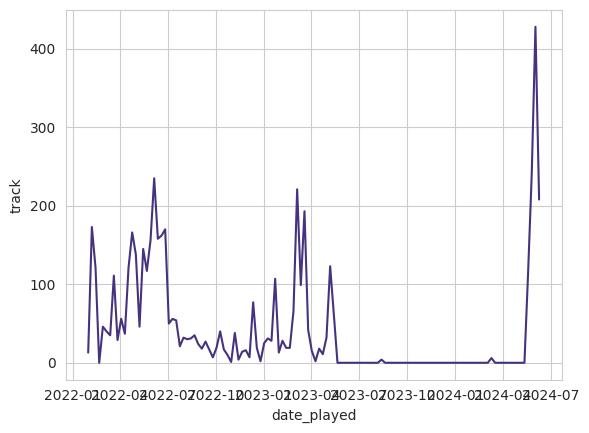

In [2]:
music = get_music_time_series(read_csv_properly("scrobbles_slayeronz.csv"), "W")["track"]
sns.lineplot(music);

We can go basically two routes: the statistical autoregressive / ARIMA approach, or the ML "linear regression is all you need" mentality. Let's test both because it's fun!

We saw in the EDA notebook that our series is statistically not stationary. To make it stationary, we can differentiate it.

A simple way to differentiate a time series, is subtracting the previous value for every value in the series. This is the First Order Differentiation

- ##### $x_t' = x_t - x_{t-1}$

But why do this in the first place? Most statistical and Machine Learning models assumes that the data is stationary. This works because we are trying to model the *rate of change* instead of the actual absolute value. If we have a good model of the rate of change, we can predict from the last known absolute value.

This is different from most i.i.d. data, where we try to predict the actual absolute values. e.g. house marret values.

adf :  -8.507783237037774
p-value :  1.189905540377504e-13


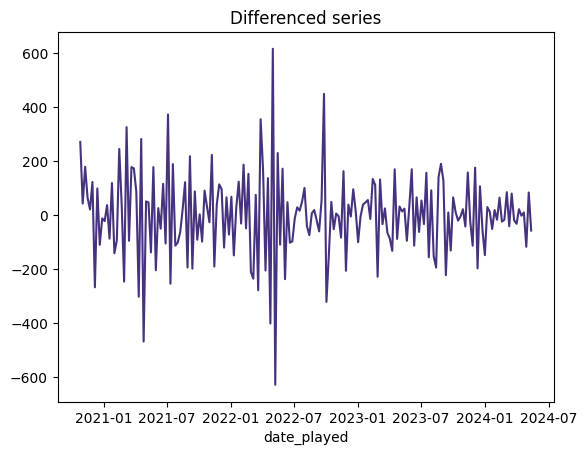

In [3]:
# Differentiation loses a data instance. That's why we are slicing music.index
music_diff = pd.Series(data=np.diff(music, n=1), index=music.index[1:])

test_augmented_df(music_diff)

sns.lineplot(music_diff) 
plt.title("Differenced series");

Now, the p-value is low (because of the lags used for testing the original series).

We can reject the null hypothesis and conclude that now the series is stationary. We can now start modelling!

But before that, let's split the data, so that we avoid biased estimators and overfitting.

In [4]:
train, test = train_test_split(music_diff, random_state=42, shuffle=False, test_size=4)

Let's apply a ARIMA model we check how it performs.

ARIMA stands for AutoRegressive Integrated Moving Average, combining both AR and MA models.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  182
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1142.364
Date:                Thu, 23 May 2024   AIC                           2290.728
Time:                        21:22:11   BIC                           2300.324
Sample:                    10-25-2020   HQIC                          2294.618
                         - 04-14-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5429      0.044    -12.343      0.000      -0.629      -0.457
ma.L1         -0.9997      1.804     -0.554      0.580      -4.536       2.537
sigma2      1.716e+04   3.11e+04      0.551      0.5

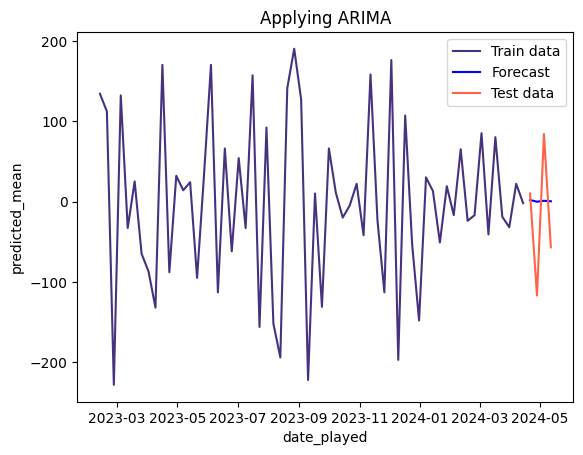

In [5]:
# Setting an ARIMA model
model = ARIMA(train, order=(1,1,1))
model = model.fit()

plot = sns.lineplot(train[120:], label="Train data")
sns.lineplot(model.forecast(len(test)), label="Forecast", ax=plot, color="blue")
sns.lineplot(test, label="Test data", ax=plot, color="tomato")
plt.title("Applying ARIMA")

# Getting ARIMA model metrics
print(model.summary())

The nature of ARIMA makes it weak for predicting seasonality and cyclic components. AIC is quite high and the prediction doesn't capture the seasonality.

Either way ARIMA is really cool and was the basis of time series forecast for a long time! If you really like the stats route, you can check out SARIMAX models.

Autoregression really isn't the way to go, and we saw it in the EDA.

Let's go the ML route then!


Let's get the original data, to try to model each component of a time series: trend, season and cyclic / residuals.

We can define a time series as a function of these components, in a additive or multiplicative way.
$$
\text{TS} = \text{trend} + \text{seasonality} + \text{cycles} \pm \text{random error}
$$

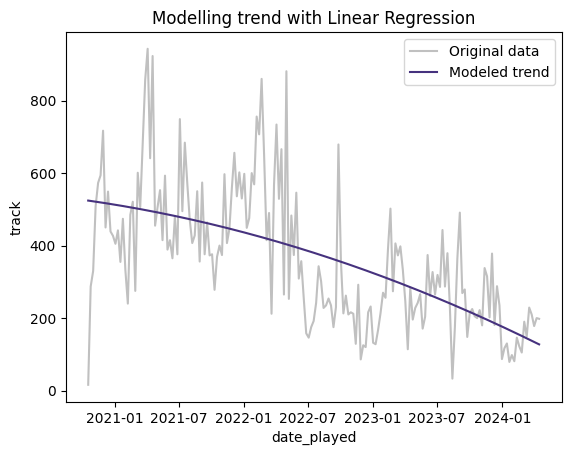

In [6]:
# Redefining train-test split for not differenciated data.
train, test = train_test_split(music, random_state=42, shuffle=False, test_size=4)

# Setting a trend line for the date index, with a constant feature.
dp = DeterministicProcess(
	train.index, constant=True, drop=True, order=2
)

# Using Linear Regression to model trend component
model = LinearRegression(fit_intercept=False)
model.fit(dp.in_sample(), train.values)

trend_pred = pd.Series(model.predict(dp.in_sample()), index=train.index)
trend_forecast = pd.Series(model.predict(dp.out_of_sample(4)), index=test.index)

plot = sns.lineplot(train, label="Original data", color="silver")
sns.lineplot(trend_pred, label="Modeled trend")
plt.title("Modelling trend with Linear Regression");

It looks like a reasonable trend to our data. We could make it more flexible by increase the order of the linear regression function.

In fact, linear regression here is used solely for trend modelling. It doesn't comply to some assumptions made to time series linear regression, and it shouldn't be considered an unbiased estimator. Because we are using it just for forecasting, and not causality, we can discard these assumptions for now.

Now, let's differentiate our data by subtracting the trend prediction from it. In this case, the regression line.

adf :  -4.328893554396045
p-value :  0.0003957269813428454


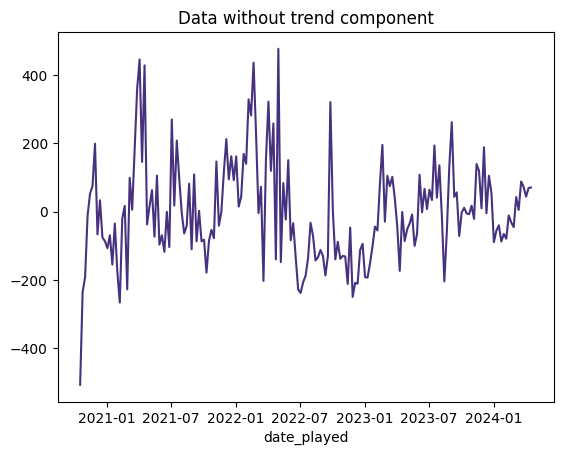

In [7]:
seasonal_train =  train - trend_pred
test_augmented_df(seasonal_train)


sns.lineplot(seasonal_train)
plt.title("Data without trend component");

Applying a augmented Dickey-Fuller test, we can statistically determine our differentiated data is stationary. We can now model the next component: **seasonality**.

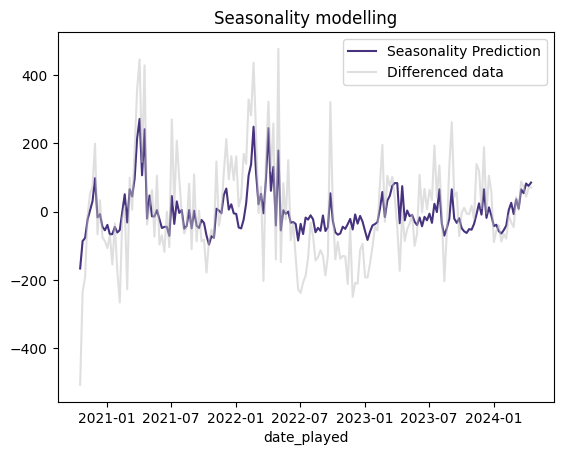

In [8]:
dp = DeterministicProcess(
	seasonal_train.index,
	order=0,
	seasonal=True,
	drop=True,
	additional_terms=
		[CalendarFourier("ME", 4), CalendarFourier("YE", 4)]
)

# Setting parameters for a hyperparameter optimization
parameters = {
	"max_depth": [5, 10 ,15, 20],
	"n_estimators": [10, 25, 50, 100, 150, 200],
	"warm_start": [True, False]
}

# Using a specific time series oriented cross validation split
cv = TimeSeriesSplit()

# Setting base model and retrieving best estimator from grid search
model = RandomForestRegressor(n_jobs=-1, criterion="absolute_error")
grid_search = GridSearchCV(model, parameters, cv=cv, scoring="neg_mean_absolute_error")
model = grid_search.fit(dp.in_sample(), seasonal_train.values).best_estimator_

# Getting predictions in sample
seasonal_pred = pd.Series(model.predict(dp.in_sample()), index=seasonal_train.index)

# Getting forecast out of sample
seasonal_forecast = pd.Series(model.predict(dp.out_of_sample(4)), index=test.index)

plot = sns.lineplot(seasonal_pred,label="Seasonality Prediction")
sns.lineplot(seasonal_train, label="Differenced data", color="silver", alpha=0.5, ax=plot)
plt.title("Seasonality modelling");

Now, we can apply the same differentiation logic to try and model the cyclic component before determining the residual as random errors.

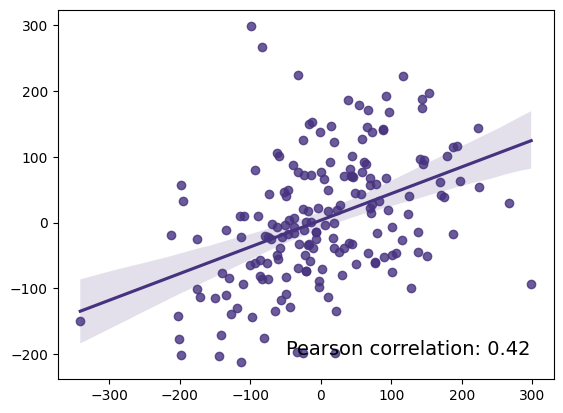

In [9]:
# Differentiating and lagging the series to analyze the residual
cyclic_diff = seasonal_train - seasonal_pred
cyclic_shifted = cyclic_diff.shift(1).dropna()

corr, _ = pearsonr(cyclic_diff[1:], cyclic_shifted)

plt.text(-50, -200, f"Pearson correlation: {corr:.2f}", fontsize=14)
sns.regplot(y=cyclic_diff[1:], x=cyclic_shifted);

In [36]:
model = LinearRegression()
model.fit(pd.DataFrame(cyclic_shifted), cyclic_diff[1:])

cyclic_pred = pd.Series(model.predict(pd.DataFrame(cyclic_diff)), index=train.index)
# cyclic_forecast = pd.Series(model.predict(), index=test.index)

def autoregressive_predict(value, model):
	def get_last_value(x):
		if isinstance(x, float):
			return [[x]]

		return [[x[-1]]]

	prediction = model.predict(get_last_value(value))
	value = np.append(value, prediction)

	if len(value) >  4:
		return value
	autoregressive_predict(value, model)


x = autoregressive_predict(cyclic_diff.iloc[-1], model)
# sns.lineplot(cyclic_diff)
# sns.lineplot(cyclic_pred);
print(x)

ValueError: Expected 2D array, got 1D array instead:
array=[-2.20322939].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [21]:
np.array(cyclic_diff[:2])[-1]

-149.61858435717653

The correlation of cyclic events based on the lag method approach doesn't really work out. It can be interpreted as a moderate correlation at most.



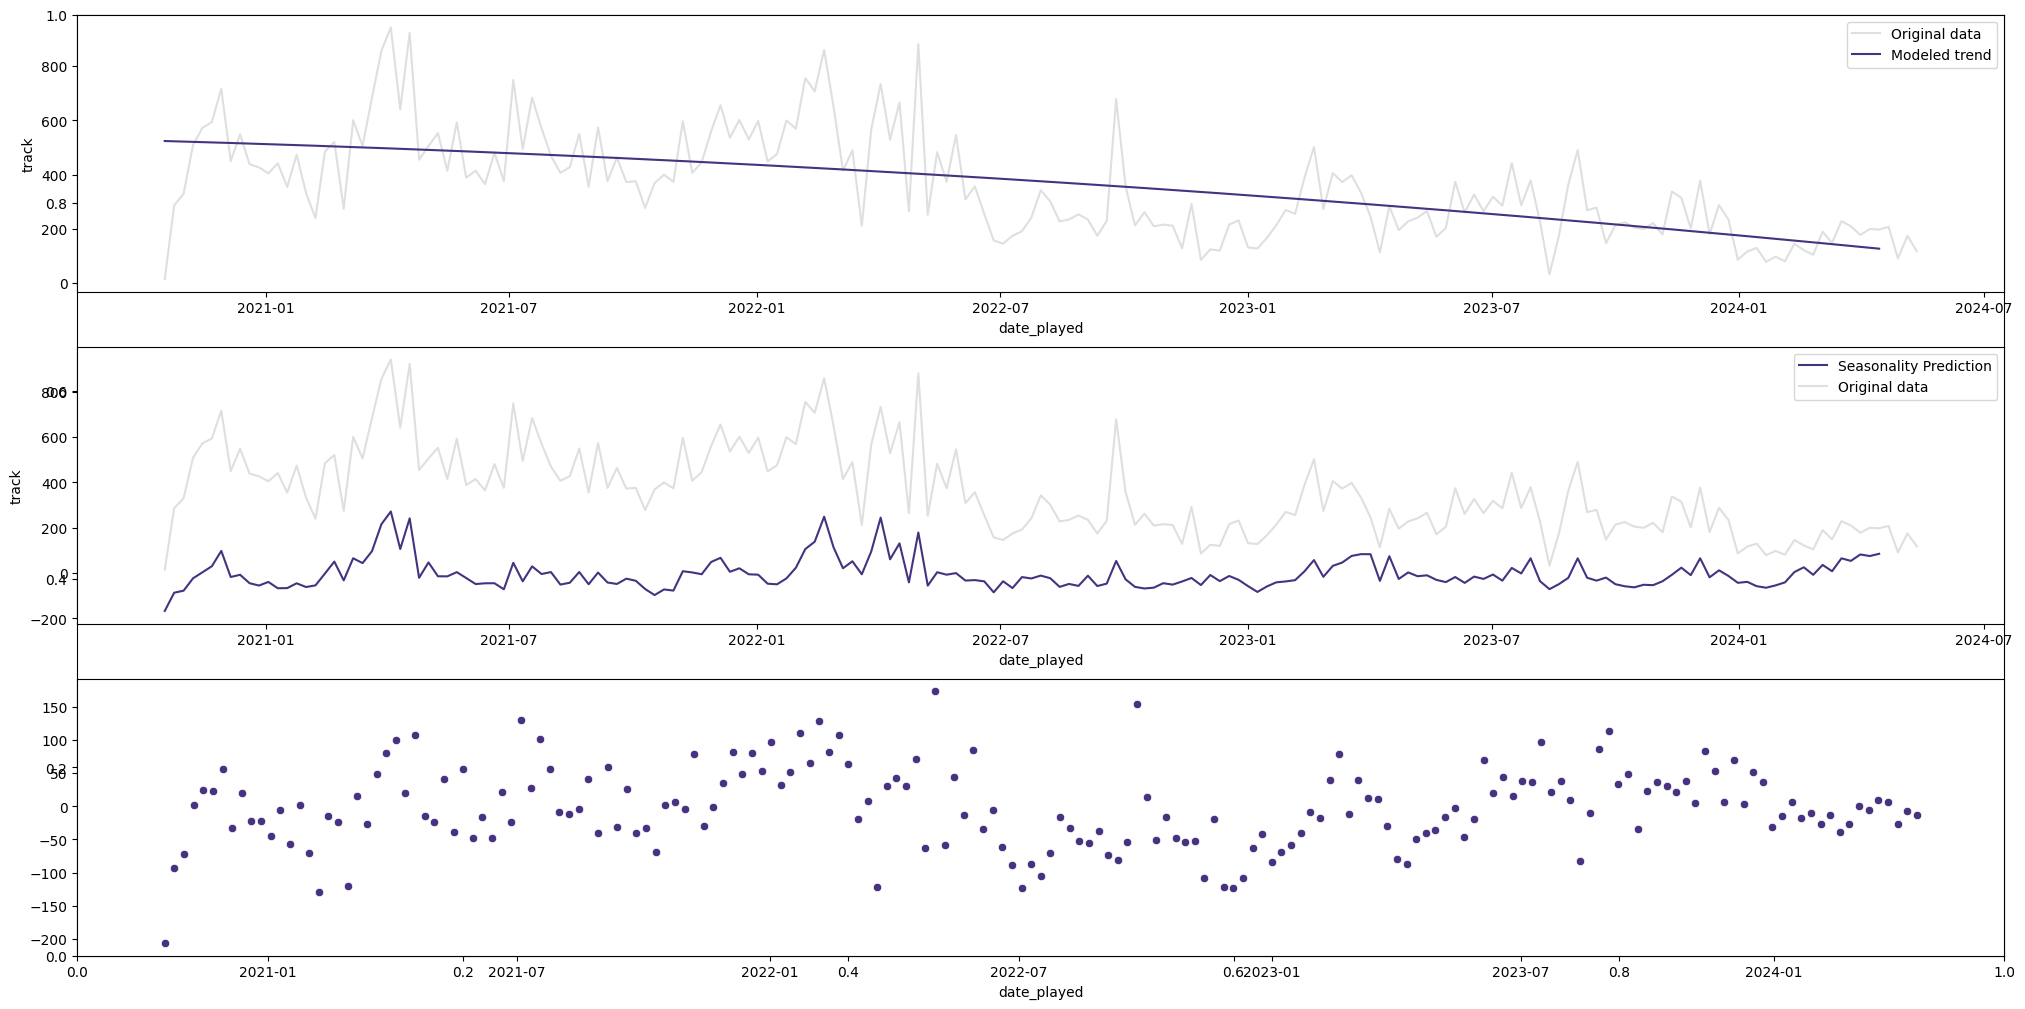

In [12]:
residuals = music - (trend_pred + seasonal_pred + cyclic_pred)

plt.subplots(figsize=(20,10), sharex=True, sharey=True)
plt.tight_layout()

plt.subplot(311)
ax1 = sns.lineplot(music, label="Original data", color="silver", alpha=0.5)
sns.lineplot(trend_pred, label="Modeled trend", ax=ax1)

plt.subplot(312)
ax2 = sns.lineplot(seasonal_pred,label="Seasonality Prediction")
sns.lineplot(music, label="Original data", color="silver", alpha=0.5, ax=ax2)

plt.subplot(313)
sns.scatterplot(residuals);


In [13]:
components_in_sample = trend_pred + seasonal_pred + 
components_forecast = trend_forecast + seasonal_forecast

sns.lineplot(music, color="silver", label="Original data")
sns.lineplot(components_in_sample, color="blue", label="In sample prediction")
sns.lineplot(components_forecast, color="red", label="Forecast")

SyntaxError: invalid syntax (1099184556.py, line 1)